## required lib

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import Ridge, LinearRegression, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from scipy.stats import uniform, randint

## train data

In [35]:
df=pd.read_csv("Train.csv")

In [36]:
df

,Trip ID,User ID,Destination,Departure Date,Return Date,Travel Type,Transportation Mode,Hotel Rating,Total Cost ($),Customer_Satisfaction
0,TRIP001,USER6303,Sydney,28-07-2024,14-09-2024,Cultural,Bus,4,2297.38,1
1,TRIP002,USER1398,Tokyo,04-01-2025,20-02-2025,Leisure,Flight,3,4171.03,1
2,TRIP003,USER8452,New York,14-09-2024,06-03-2025,Business,Cruise,4,695.11,3
3,TRIP004,USER5289,Sydney,06-07-2024,14-08-2024,Adventure,Flight,2,1371.81,3
4,TRIP005,USER9783,New York,26-08-2024,25-11-2024,Cultural,Bus,2,691.52,7
...,...,...,...,...,...,...,...,...,...,...
19795,TRIP19996,USER4173,Istanbul,26-04-2024,04-06-2024,Leisure,Bus,5,1954.61,1
19796,TRIP19997,USER2394,Barcelona,13-09-2024,25-09-2024,Leisure,Bus,4,3868.49,8
19797,TRIP19998,USER6638,Bangkok,23-12-2024,26-12-2024,Cultural,Car,4,2255.53,2
19798,TRIP19999,USER8763,New York,30-01-2025,05-04-2025,Leisure,Cruise,4,4630.54,10


In [37]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19800 entries, 0 to 19799
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Trip ID                19800 non-null  object 
 1   User ID                19800 non-null  object 
 2   Destination            19800 non-null  object 
 3   Departure Date         19800 non-null  object 
 4   Return Date            19800 non-null  object 
 5   Travel Type            19800 non-null  object 
 6   Transportation Mode    19800 non-null  object 
 7   Hotel Rating           19800 non-null  int64  
 8   Total Cost ($)         19800 non-null  float64
 9   Customer_Satisfaction  19800 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 1.5+ MB
None


In [38]:
df.isna().sum()

Trip ID                  0
User ID                  0
Destination              0
Departure Date           0
Return Date              0
Travel Type              0
Transportation Mode      0
Hotel Rating             0
Total Cost ($)           0
Customer_Satisfaction    0
dtype: int64

In [39]:
df["Travel Type"].unique()

array(['Cultural', 'Leisure', 'Business', 'Adventure', 'Beach', 'Family'],
      dtype=object)

In [40]:
dest_encoder = preprocessing.LabelEncoder()
df['Destination_en']= dest_encoder.fit_transform(df['Destination'])
df['Destination_en']

0        8
1        9
2        5
3        8
4        5
        ..
19795    3
19796    1
19797    0
19798    5
19799    8
Name: Destination_en, Length: 19800, dtype: int32

In [41]:
ttype_encoder = preprocessing.LabelEncoder()
df['Travel Type_en']= ttype_encoder.fit_transform(df['Travel Type'])
df['Travel Type_en']

0        3
1        5
2        2
3        0
4        3
        ..
19795    5
19796    5
19797    3
19798    5
19799    5
Name: Travel Type_en, Length: 19800, dtype: int32

In [42]:
tmode_encoder = preprocessing.LabelEncoder()
df['Transportation Mode_en']= tmode_encoder.fit_transform(df['Transportation Mode'])
df['Transportation Mode_en']

0        0
1        3
2        2
3        3
4        0
        ..
19795    0
19796    0
19797    1
19798    2
19799    2
Name: Transportation Mode_en, Length: 19800, dtype: int32

In [43]:
df['Departure Date'] = pd.to_datetime(df['Departure Date'])
df['Return Date'] = pd.to_datetime(df['Return Date'])

C:\Users\abinj\AppData\Local\Temp\ipykernel_17140\3891269809.py:1: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Departure Date'] = pd.to_datetime(df['Departure Date'])
C:\Users\abinj\AppData\Local\Temp\ipykernel_17140\3891269809.py:2: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Return Date'] = pd.to_datetime(df['Return Date'])


In [44]:
df['date_difference'] = (df['Return Date'] - df['Departure Date']).dt.days

In [45]:
df["return month"]=df["Return Date"].dt.month
df["dept month"]=df["Departure Date"].dt.month
df["return year"]=df["Return Date"].dt.year
df["dept year"]=df["Departure Date"].dt.year

In [46]:
df['dept season'] = df['dept month'].apply(lambda x: 
                                1 if x in [12, 1, 2] else  # Winter
                                2 if x in [3, 4, 5] else   # Spring
                                3 if x in [6, 7, 8] else   # Summer
                                4)                          # Fall

In [47]:
df['Cost Per Day'] = df['Total Cost ($)'] / df['date_difference']
df['Cost Per Rating Point'] = df['Total Cost ($)'] / df['Hotel Rating']

In [48]:
df['Hotel_Cost_Interaction'] = df['Hotel Rating'] * df['Total Cost ($)']
df['Duration_Cost_Ratio'] = df['date_difference'] / df['Total Cost ($)']
df['Hotel_Duration_Interaction'] = df['Hotel Rating'] * df['date_difference']

In [49]:
df['Is_Long_Trip'] = df['date_difference'] > df['date_difference'].median()
df['Is_Expensive'] = df['Total Cost ($)'] > df['Total Cost ($)'].median()
df['Is_High_Rating'] = df['Hotel Rating'] >= 4

In [50]:
df.columns

Index(['Trip ID', 'User ID', 'Destination', 'Departure Date', 'Return Date',
       'Travel Type', 'Transportation Mode', 'Hotel Rating', 'Total Cost ($)',
       'Customer_Satisfaction', 'Destination_en', 'Travel Type_en',
       'Transportation Mode_en', 'date_difference', 'return month',
       'dept month', 'return year', 'dept year', 'dept season', 'Cost Per Day',
       'Cost Per Rating Point', 'Hotel_Cost_Interaction',
       'Duration_Cost_Ratio', 'Hotel_Duration_Interaction', 'Is_Long_Trip',
       'Is_Expensive', 'Is_High_Rating'],
      dtype='object')

In [51]:
X=df[['Hotel Rating', 'Total Cost ($)', 'Destination_en', 'Travel Type_en',
    'Transportation Mode_en', 'date_difference', 'return month',
    'dept month', 'return year', 'dept year', 'dept season',
    'Hotel_Cost_Interaction', 'Duration_Cost_Ratio',
    'Hotel_Duration_Interaction', 'Is_Long_Trip', 'Is_Expensive',
    'Is_High_Rating']]

# X=df[['Hotel Rating', 'Total Cost ($)', 'Destination_en', 'Travel Type_en',
#     'Transportation Mode_en', 'date_difference', 'return month',
#     'dept month', 'dept season','Hotel_Cost_Interaction', 'Duration_Cost_Ratio', 'Is_Long_Trip', 'Is_Expensive',
#     'Is_High_Rating']]

y=df["Customer_Satisfaction"]

In [52]:
scaler = StandardScaler()

## build ensemble with random search opt

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

scaler = StandardScaler()
train_features = scaler.fit_transform(X_train)
test_features = scaler.transform(X_test)

param_grids = {
    'lightgbm': {
        'n_estimators': [500, 800, 1000],
        'learning_rate': [ 0.05, 0.08, 0.1],
        'num_leaves': [20, 31, 50],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0]
    },
    'xgboost': {
        'n_estimators': [500, 800, 1000],
        'learning_rate': [ 0.05, 0.08, 0.1, .02],
        'max_depth': [6, 8, 10],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0, .02]
    },
    'catboost': {
        'iterations': [500, 800, 1000],
        'learning_rate': [ 0.05, 0.08, 0.1, .02],
        'depth': [6, 8, 10]
    },
    'random_forest': {
        'n_estimators': [500, 800, 1000],
        'max_depth': [6, 8, 10]
    },
    'gradient_boosting': {
        'n_estimators': [500, 800, 1000],
        'learning_rate': [ 0.05, 0.08, 0.1, .02],
        'max_depth': [6, 8, 10]
    },
    'hist_gradient_boosting': {
        'max_iter': randint(500, 1000),
        'learning_rate': uniform(0.01, 0.1),
        'max_depth': randint(6, 15)
    }
}

base_models = {
    'lightgbm': lgb.LGBMRegressor(objective='regression', random_state=42),
    'xgboost': xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
    'catboost': CatBoostRegressor(loss_function='RMSE', random_seed=42, verbose=0),
    'random_forest': RandomForestRegressor(random_state=42),
    'gradient_boosting': GradientBoostingRegressor(random_state=42),
    'hist_gradient_boosting': HistGradientBoostingRegressor(random_state=42),
}

results = {}
optimized_models = {}

for name, model in base_models.items():
    print(f"Optimizing {name}...")
    
    if name in param_grids:
        search = RandomizedSearchCV(
            model, param_distributions=param_grids[name], 
            n_iter=20, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1, random_state=42
        )
        search.fit(train_features, y_train)
        best_model = search.best_estimator_
    else:
        best_model = model
        best_model.fit(train_features, y_train)
    
    val_pred = best_model.predict(test_features)
    val_rmse = np.sqrt(mean_squared_error(y_test, val_pred))
    
    print(f"{name} best RMSE: {val_rmse:.4f}")
    results[name] = {'model': best_model, 'rmse': val_rmse}
    optimized_models[name] = best_model

best_models = sorted(results.items(), key=lambda x: x[1]['rmse'])[:4]
ensemble_estimators = [(name, model['model']) for name, model in best_models]

ensemble = VotingRegressor(estimators=ensemble_estimators)
ensemble.fit(train_features, y_train)

ensemble_val_pred = ensemble.predict(test_features)
ensemble_rmse = np.sqrt(mean_squared_error(y_test, ensemble_val_pred))
print(f"\nEnsemble validation RMSE: {ensemble_rmse:.4f}")

Optimizing lightgbm...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000245 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1351
[LightGBM] [Info] Number of data points in the train set: 15840, number of used features: 17
[LightGBM] [Info] Start training from score 5.515088


e:\python\Kaggle_Hack\.venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


lightgbm best RMSE: 2.9276
Optimizing xgboost...
xgboost best RMSE: 2.8902
Optimizing catboost...
catboost best RMSE: 2.9060
Optimizing random_forest...


e:\python\Kaggle_Hack\.venv\lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 9 is smaller than n_iter=20. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


random_forest best RMSE: 2.8866
Optimizing gradient_boosting...
gradient_boosting best RMSE: 2.9432
Optimizing hist_gradient_boosting...
hist_gradient_boosting best RMSE: 2.8835

Ensemble validation RMSE: 2.8875


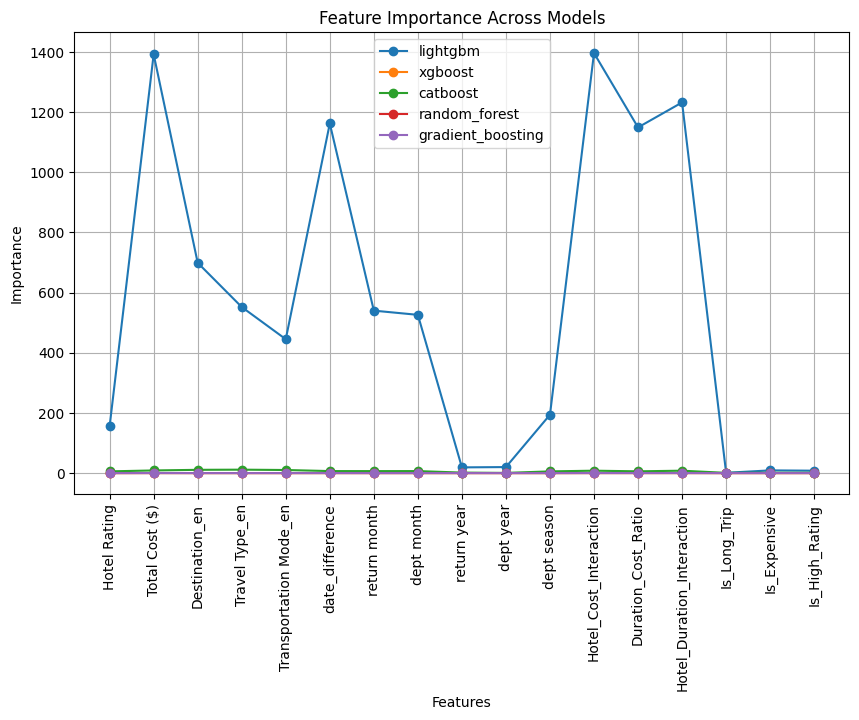

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

feature_importances = {}

# Models that have feature importance attributes
importance_models = ['lightgbm', 'xgboost', 'catboost', 'random_forest', 'gradient_boosting']

for name in importance_models:
    if name in optimized_models:
        model = optimized_models[name]
        
        if hasattr(model, 'feature_importances_'):
            feature_importances[name] = model.feature_importances_

feature_importance_df = pd.DataFrame(feature_importances, index=X.columns)

plt.figure(figsize=(10, 6))
for model_name, importance_values in feature_importances.items():
    plt.plot(feature_importance_df.index, importance_values, marker='o', label=model_name)

plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importance Across Models")
plt.legend()
plt.grid()
plt.show()

## test data

In [55]:
tf=pd.read_csv("Test.csv")
tf

,Trip ID,User ID,Destination,Departure Date,Return Date,Travel Type,Transportation Mode,Hotel Rating,Total Cost ($),Customer_Satisfaction
0,TRIP10651,USER1429,Tokyo,24-11-2024,26-12-2024,Family,Flight,2,2773.07,NaN
1,TRIP02042,USER8789,Rome,03-12-2024,21-02-2025,Cultural,Train,1,3809.85,NaN
2,TRIP08669,USER1090,Barcelona,04-07-2024,11-02-2025,Leisure,Flight,5,2648.33,NaN
3,TRIP01115,USER5405,Paris,17-06-2024,19-08-2024,Family,Flight,3,3802.00,NaN
4,TRIP13903,USER9119,Dubai,18-11-2024,04-01-2025,Cultural,Train,2,2982.42,NaN
...,...,...,...,...,...,...,...,...,...,...
195,TRIP11966,USER7504,Paris,29-04-2024,10-06-2024,Cultural,Train,4,1821.41,NaN
196,TRIP01693,USER3046,Rome,04-03-2025,11-03-2025,Beach,Train,1,4524.99,NaN
197,TRIP06217,USER2550,Dubai,12-12-2024,15-03-2025,Family,Cruise,4,4465.99,NaN
198,TRIP09460,USER9124,Tokyo,23-04-2024,01-12-2024,Beach,Car,3,2974.99,NaN


In [56]:
tf.isna().sum()

Trip ID                    0
User ID                    0
Destination                0
Departure Date             0
Return Date                0
Travel Type                0
Transportation Mode        0
Hotel Rating               0
Total Cost ($)             0
Customer_Satisfaction    200
dtype: int64

In [57]:
tf['Destination_en']= dest_encoder.transform(tf['Destination'])
tf['Travel Type_en']= ttype_encoder.transform(tf['Travel Type'])
tf['Transportation Mode_en']= tmode_encoder.transform(tf['Transportation Mode'])
tf['Departure Date'] = pd.to_datetime(tf['Departure Date'])
tf['Return Date'] = pd.to_datetime(tf['Return Date'])
tf['date_difference'] = (tf['Return Date'] - tf['Departure Date']).dt.days
tf["return month"]=tf["Return Date"].dt.month
tf["dept month"]=tf["Departure Date"].dt.month
tf["return year"]=tf["Return Date"].dt.year
tf["dept year"]=tf["Departure Date"].dt.year

C:\Users\abinj\AppData\Local\Temp\ipykernel_17140\1229232360.py:4: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  tf['Departure Date'] = pd.to_datetime(tf['Departure Date'])
C:\Users\abinj\AppData\Local\Temp\ipykernel_17140\1229232360.py:5: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  tf['Return Date'] = pd.to_datetime(tf['Return Date'])


In [58]:
tf['dept season'] = tf['dept month'].apply(lambda x: 
                                1 if x in [12, 1, 2] else  # Winter
                                2 if x in [3, 4, 5] else   # Spring
                                3 if x in [6, 7, 8] else   # Summer
                                4)                          # Fall
tf['Cost Per Day'] = tf['Total Cost ($)'] / tf['date_difference']
tf['Cost Per Rating Point'] = tf['Total Cost ($)'] / tf['Hotel Rating']
tf['Hotel_Cost_Interaction'] = tf['Hotel Rating'] * tf['Total Cost ($)']
tf['Duration_Cost_Ratio'] = tf['date_difference'] / tf['Total Cost ($)']
tf['Hotel_Duration_Interaction'] = tf['Hotel Rating'] * tf['date_difference']
tf['Is_Long_Trip'] = tf['date_difference'] > tf['date_difference'].median()
tf['Is_Expensive'] = tf['Total Cost ($)'] > tf['Total Cost ($)'].median()
tf['Is_High_Rating'] = tf['Hotel Rating'] >= 4

In [59]:
X=tf[['Hotel Rating', 'Total Cost ($)', 'Destination_en', 'Travel Type_en',
    'Transportation Mode_en', 'date_difference', 'return month',
    'dept month', 'return year', 'dept year', 'dept season',
    'Hotel_Cost_Interaction', 'Duration_Cost_Ratio',
    'Hotel_Duration_Interaction', 'Is_Long_Trip', 'Is_Expensive',
    'Is_High_Rating']]
# X=tf[['Hotel Rating', 'Total Cost ($)', 'Destination_en', 'Travel Type_en',
#     'Transportation Mode_en', 'date_difference', 'return month',
#     'dept month', 'dept season','Hotel_Cost_Interaction', 'Duration_Cost_Ratio', 'Is_Long_Trip', 'Is_Expensive',
#     'Is_High_Rating']]

In [60]:
X_test = scaler.transform(X)
y_pred=ensemble.predict(X_test)

In [61]:
y_pred

array([5.55612024, 5.54176049, 5.63111504, 5.56724417, 5.4685875 ,
       5.51506579, 5.40097496, 5.45567282, 5.45787236, 5.40828384,
       5.48855   , 5.43179872, 5.45904465, 5.4735567 , 5.62639142,
       5.62851374, 5.3314167 , 5.56342237, 5.54402597, 5.54015716,
       5.44709308, 5.42487736, 5.37152363, 5.56497231, 5.58371464,
       5.66414914, 5.22948129, 5.63322547, 5.48416171, 5.32978562,
       5.58621235, 5.7218014 , 5.49093639, 5.4606537 , 5.58935462,
       5.45578745, 5.48503366, 5.42218302, 5.38096966, 5.45305071,
       5.45570319, 5.5149144 , 5.44388636, 5.49455689, 5.42316823,
       5.33886496, 5.4942293 , 5.45983663, 5.85540528, 5.5045338 ,
       5.49660699, 5.71700078, 5.62298312, 5.87699816, 5.29979274,
       5.57888613, 5.52038751, 5.52787844, 5.42268979, 5.39163948,
       5.42821926, 5.56608737, 5.53735977, 5.44956782, 5.488228  ,
       5.53755729, 5.35543601, 5.3980533 , 5.62826473, 5.4490647 ,
       5.44810307, 5.56653191, 5.64906856, 5.54982939, 5.44343

## visualize

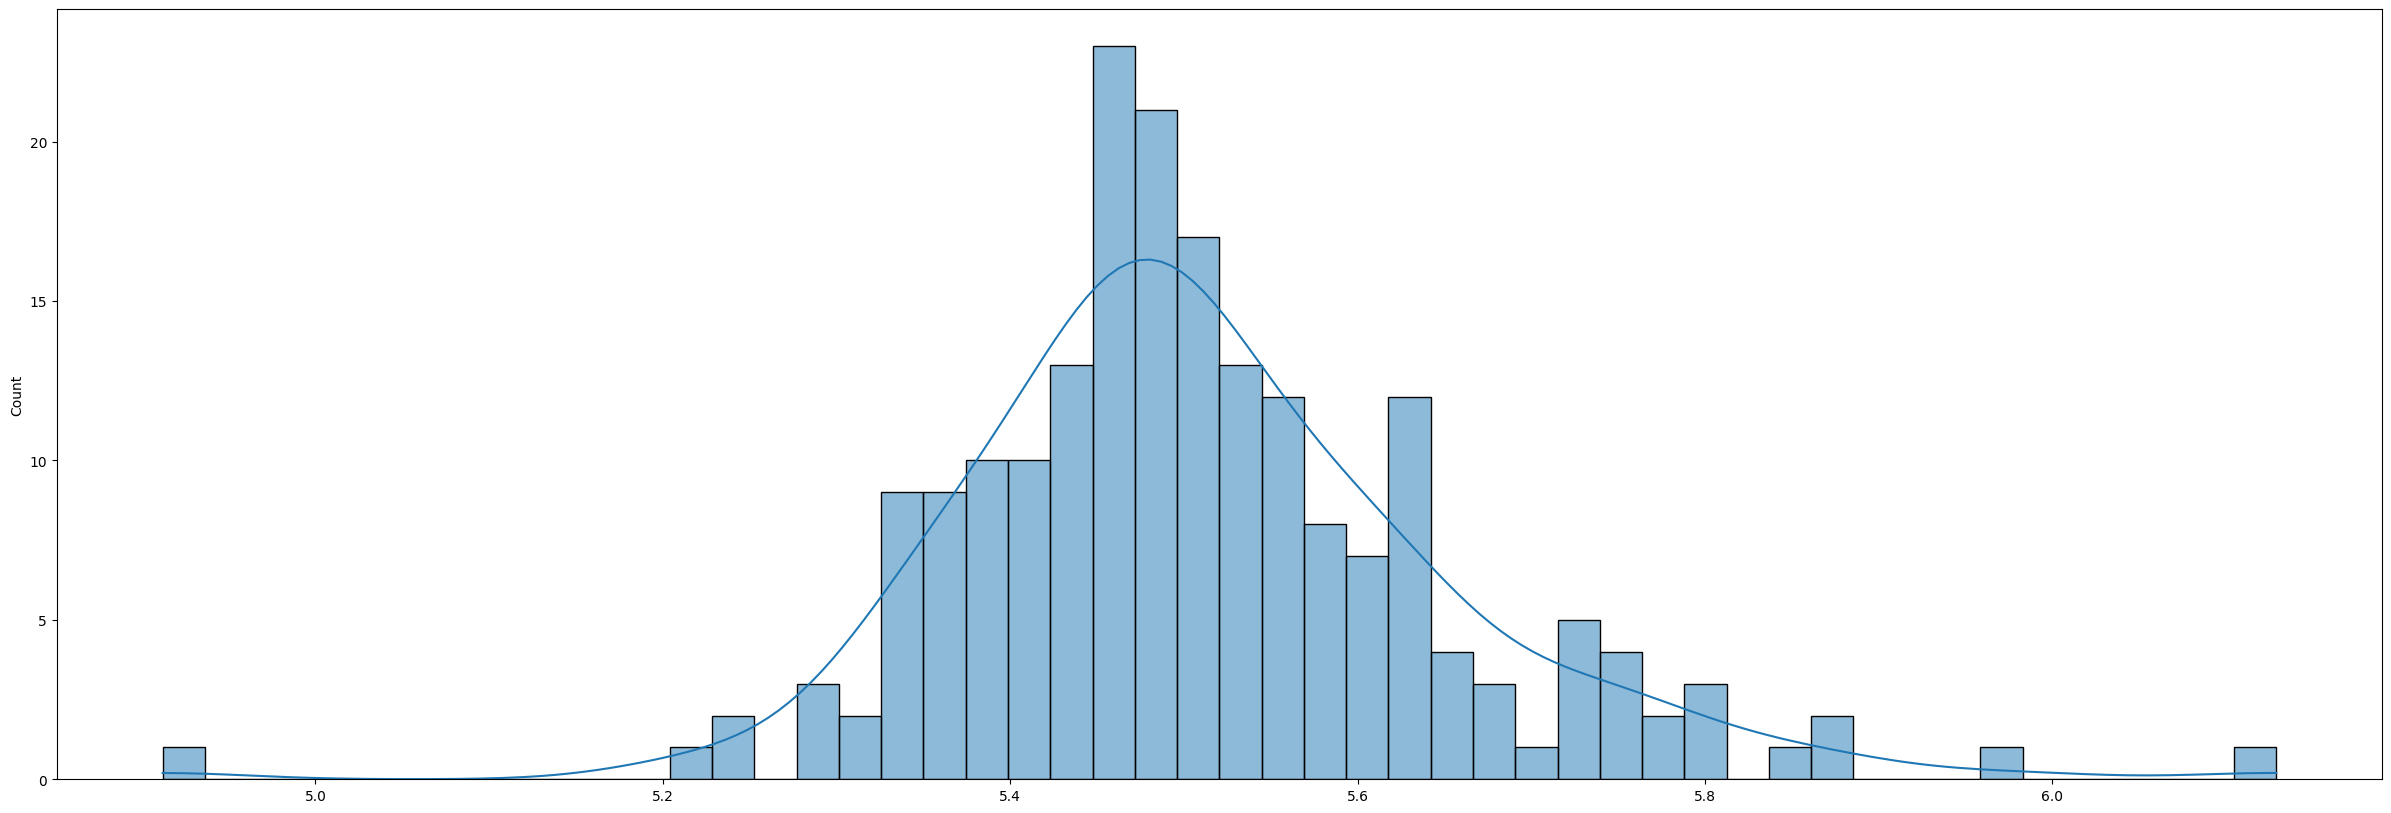

In [62]:
plt.figure(figsize=(30,10))
sns.histplot(y_pred, kde=True, bins=50)
plt.show()

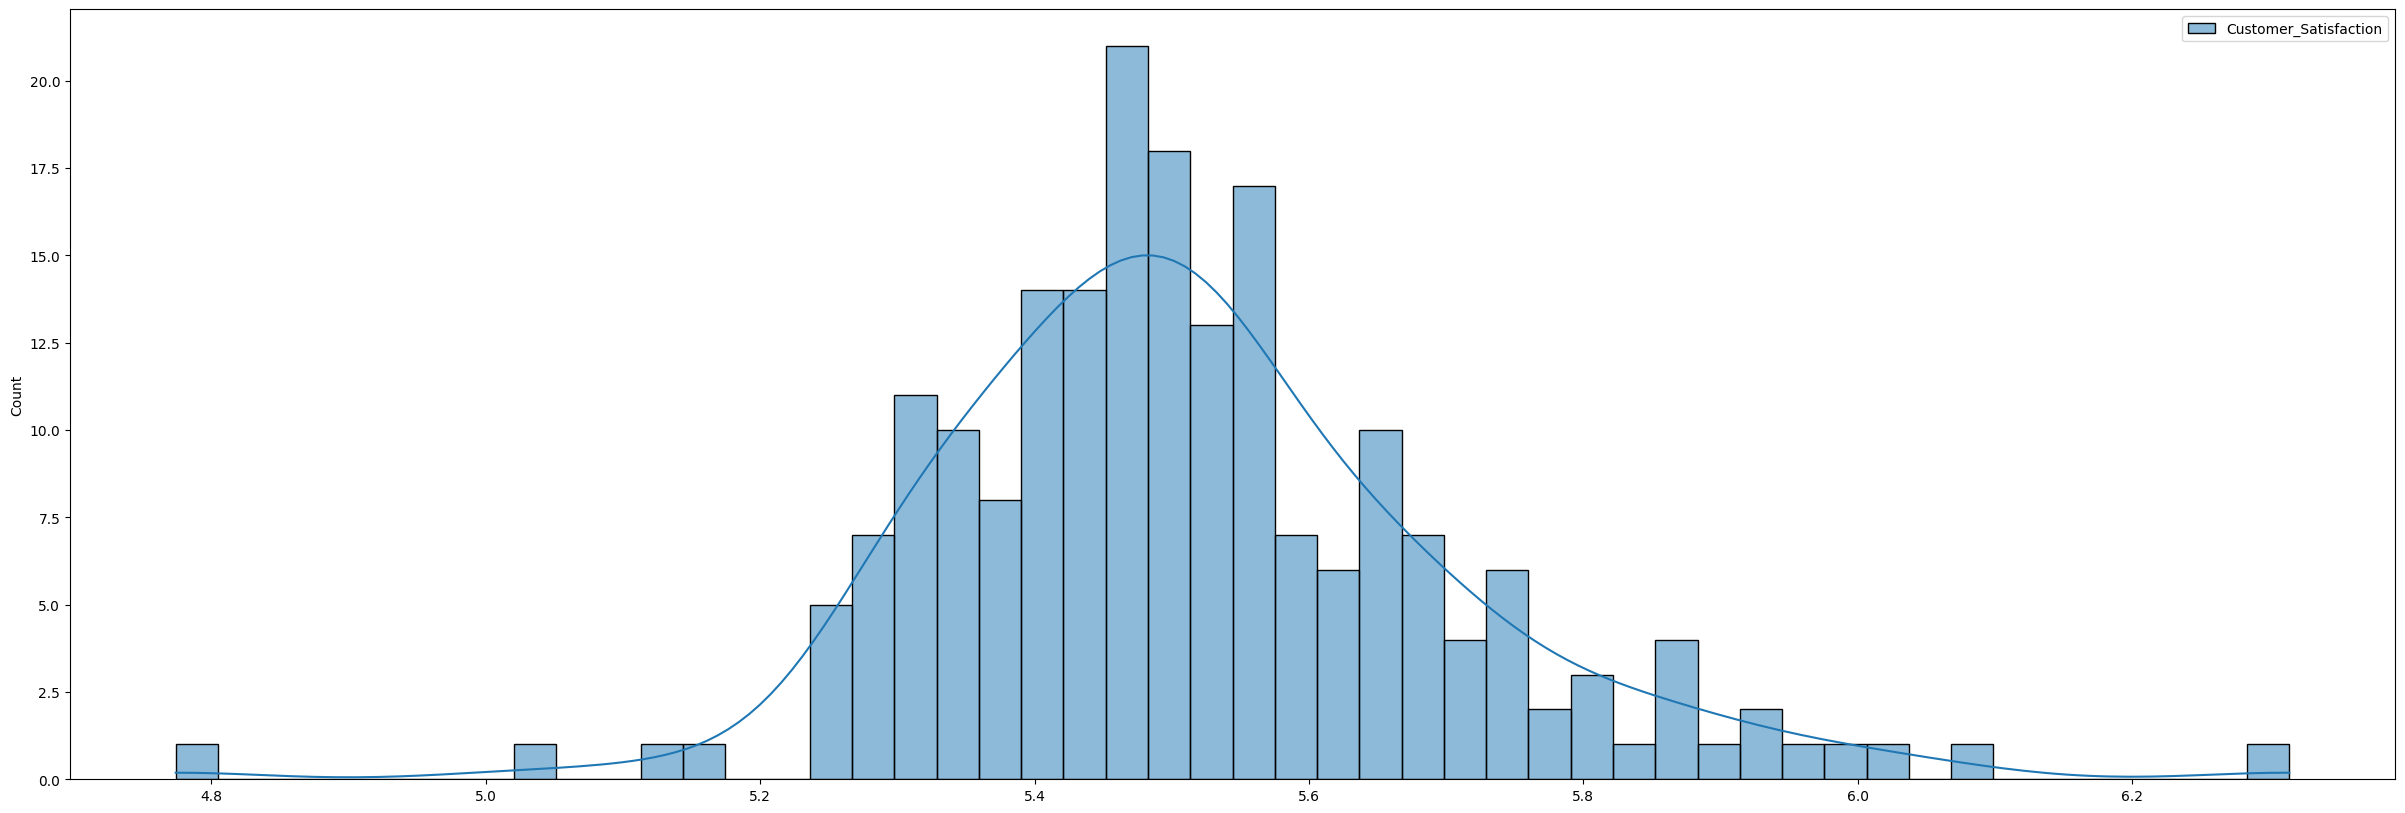

In [63]:
gf=pd.read_csv("predictions1.csv")
plt.figure(figsize=(30,10))
sns.histplot(gf, kde=True, bins=50)
plt.show()

## save

In [64]:
prediction=pd.DataFrame()
prediction["Customer_Satisfaction"]=y_pred
prediction.to_csv("predictions2.csv", index=False)

In [65]:
##pred1 has best result yet